# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фото определит приблизительный возраст человека. Для этого предоставлен набор фотографий людей с указанием возраста. Следует построить и обучить сверточную нейронную сеть на датасете с фотографиями и добиться значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [1]:
# Импортируем необходимые для работы библиотеки.

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Открываем датасет и настраиваем его.

labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# Выводим первые строки датафрейма.

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Выводим общую информацию о датафрейме.

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# Просматриваем статистические характеристики датафрейма.

labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Выявляем наличие дубликатов.

print("Количество дубликатов:", labels.duplicated().sum())

Количество дубликатов: 0


In [7]:
# Выделяем признаки и целевой признак.

features, target = next(datagen_flow)

In [8]:
# Определяем количество батчей.

print("Количество батчей:", len(datagen_flow))

Количество батчей: 238


In [9]:
# Выводим размеры батча.

print(features.shape)

(32, 224, 224, 3)


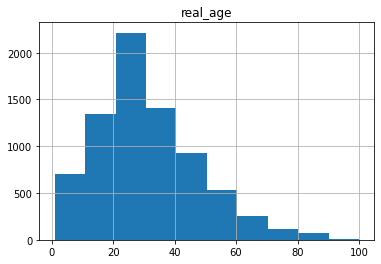

In [10]:
# Строим график распределения возрастов по всей выборке.

labels.hist(bins=10);

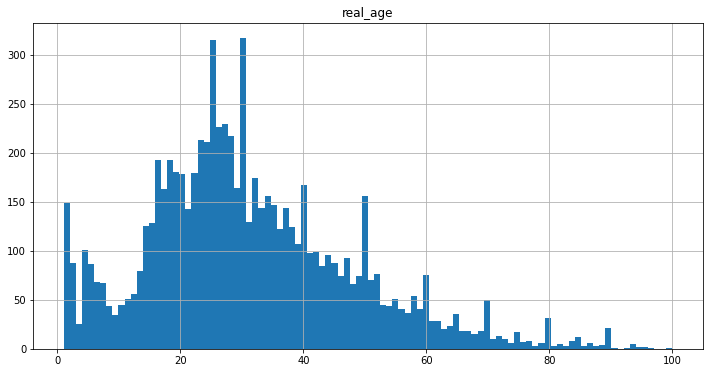

In [11]:
# Строим более детализированную гистограмму с большим количеством корзин.

labels.hist(bins=100, figsize = (12, 6));

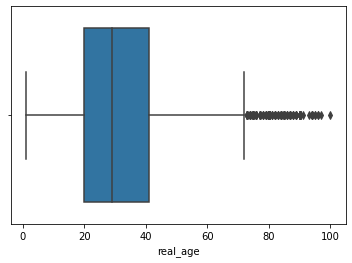

In [12]:
# Строим boxplot для выявления квартилей.

sns.boxplot(x=labels['real_age']);

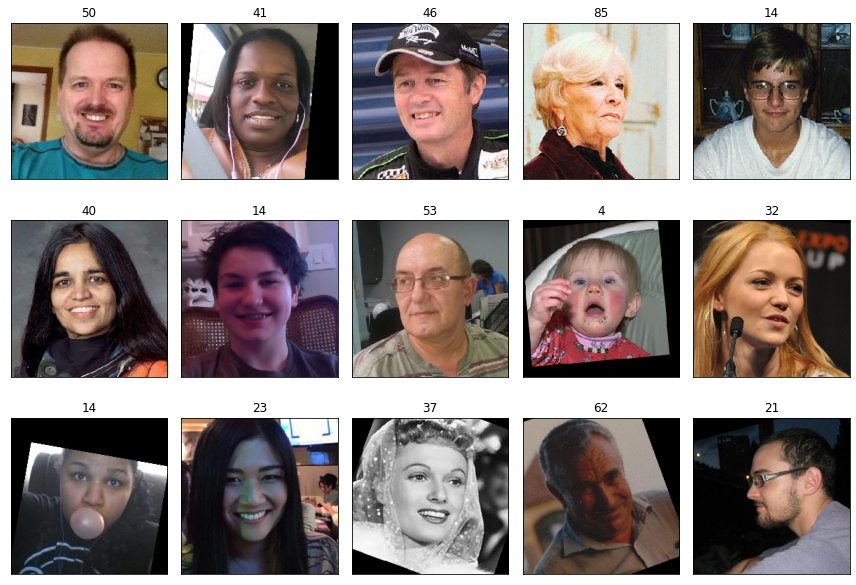

In [13]:
# Просматриваем несколько фотографий 

fig = plt.figure(figsize=(12, 9))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

**Выводы**

1. В предоставленном датасете, в папке "final_files", находится 7591 фотография людей разных возрастов, полов и рас, чего вполне достаточно для достижения высокого качества модели. В сопровождающем файле "labels.csv" содержатся соответствующие названия файлов с изображениями (столбец 'file_name') и возрастами людей (столбец 'real_age').


2. В столбце с названиами файлов тип данных - object, в столбце с возрастом - int64. Пропущенных данных нет. Дубликатов среди строк нет. Статистика возрастов без аномалий.


3. В ходе предварительной обработки датасет разбит на 238 батчей по 32 объекта в каждом батче (кроме последнего). Размер входного изображения приведен к 224х224 пикселей. Таким образом, форма каждого тензора с признаками следующая: (32, 224, 224, 3).


4. Как показывает гистограмма, возраст во всей выборке имеет близкое к нормальному распределение, с небольшим смещением влево и дополнительной вершиной у начала оси, с медианой на уровне 29 лет и средним значением - около 31 года. "Ящик с усами" показывает, что основная часть значений сосредоточена в интервале до 75 лет. В целом данные представлены с большим разбросом по возрасту, что положительно повлияет на качество модели.


5. Про качество фотографий можно отметить, что люди на них изображены не только анфас, но и под углом, и даже в профиль. Четкость и яркость фотографий также разные. Среди них встречаются в том числе и монохромные (черно-белые). Часть фотографий повернута на некоторый угол. Для повышения качества модели можно применить аугментацию, в том числе, отражения по вертикали, повороты и сдвиги.

## Обучение модели

```python

# Импортируем необходимые для работы библиотеки.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Загружаем обучающую выборку

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                       horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory=path+'final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   subset='training',
                                                   seed=12345)
    return train_data


# Загружаем тестовую выборку

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path+'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='validation',
                                                 seed=12345)
    return test_data


# Создаем модель

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


# Обучаем модель

def train_model(model, train_data, test_data, batch_size=None, epochs=9,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```python
# Результаты  обучения
```
```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/9
178/178 - 59s - loss: 237.1073 - mae: 11.1369 - val_loss: 1047.0736 - val_mae: 27.7472
Epoch 2/9
178/178 - 42s - loss: 74.4967 - mae: 6.5153 - val_loss: 540.5828 - val_mae: 17.8397
Epoch 3/9
178/178 - 42s - loss: 51.1133 - mae: 5.4568 - val_loss: 193.5492 - val_mae: 10.7543
Epoch 4/9
178/178 - 43s - loss: 35.4659 - mae: 4.5319 - val_loss: 127.9157 - val_mae: 8.6190
Epoch 5/9
178/178 - 42s - loss: 27.0683 - mae: 3.9957 - val_loss: 80.2321 - val_mae: 6.7840
Epoch 6/9
178/178 - 40s - loss: 21.4575 - mae: 3.5332 - val_loss: 70.6362 - val_mae: 6.4480
Epoch 7/9
178/178 - 40s - loss: 17.7716 - mae: 3.2097 - val_loss: 71.6059 - val_mae: 6.2613
Epoch 8/9
178/178 - 46s - loss: 15.2816 - mae: 3.0009 - val_loss: 64.0998 - val_mae: 5.8619
Epoch 9/9
178/178 - 47s - loss: 13.2728 - mae: 2.7970 - val_loss: 64.3950 - val_mae: 5.8492
                
                
60/60 - 11s - loss: 64.3950 - mae: 5.8492
Test MAE: 5.8492

```

**Выводы**

1. Определение возраста человека по фотографии предполагает решение задачи регрессии, поскольку число в ответе - это количество лет. Прогноз и верный ответ можно сравнить: чем дальше предсказание от ответа, тем оно хуже.


2. Для работы использована сверточная нейронная сеть архитектуры ResNet50. В отличие от других архитектур, ResNet50 справляется с задачей гораздо быстрее, без долгого подбора параметров, и с лучшим качеством.  


3. Для ускорения обработки код запущен в отдельном GPU-тренажёре, для чего написаны следующие функции:
- `load_train(path)` и `load_test(path)` - загрузка обучающей и тестовой (валидационной) выборок с выделением 25% на тест, а также аугментацией (горизонтальный флип) в трейне, с использованием flow_from_dataframe в качестве метода ImageDataGenerator;
- `create_model(input_shape)` - создание модели с указанием пути к заранее загруженным на сервер весам и обновлением слоя с пулингом и полносвязного слоя с единственным нейроном (для задачи регрессии нужен всего один нейрон, который вернет число-предсказание), с использованием функции активации ReLU (положительные прогнозы сети данная функция не меняет, а все отрицательные - приводит к нулю) и функцией потерь для регрессии - Mean Squared Error (чаще всего нейронные сети с функцией потерь MSE обучаются быстрее, чем MAE);
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - обучение модели, состоящее из 9 эпох, которых вполне хватило для получения требуемого качества модели (MAE < 8), достигшего уровня 5.85.

## Анализ обученной модели

1. Качество обученной в настоящем исследовании модели достигло уровня MAE = 5.85, т.е. ошибка в определении возраста в тестовой выборке составляет в среднем 5 лет и 10 месяцев, что гораздо точнее, чем требовалось (не более 8 лет). Учитывая, что различные традиционные экспертизы по визуальному определению возраста допускают наличие даже большей погрешности, можно заключить, что модель продемонстрировала вполне высокое качество. 


2. Целью исследования было создание модели для внедрения системы компьютерного зрения, способной решать 2 задачи:
- анализ покупки клиента и предложение товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроль добросовестности кассиров при продаже алкоголя.

    Первая задача при использовании результатов работы созданной модели вполне решаема. Однако вторую задачу при погрешности почти в 6 лет решить весьма непросто, поскольку данный разброс не позволит системе однозначно определить верность оценки кассиром возраста покупателя при продаже алкоголя. В этом случае, для повышения эффективности системы, можно ввести обязательную проверку кассиром документов у покупателя, которому на вид менее 18+6 лет.

**Общие выводы и наблюдения**

1. Оценка реального возраста по изображениям - сложная задача, требующая автоматического обнаружения и интерпретации черт лица. Это может быть использовано в различных сферах, таких как системы видеонаблюдения, сбор демографической статистики, бизнес-аналитика и профилирование клиентов, а также поисковая оптимизация в базах данных. Заметим, что задачу регрессии часто можно трансформировать в задачу классификации по возрастным группам. Это уже кажется более легко решаемой проблемой и, по моему мнению, - более подходящей целью данного исследования в части возможности предложения клиенту потенциально интересных для его возрастной группы товаров.


2. Необходимо также отметить, что ввиду естественных причин, ошибка в определении возраста имеет непреодолимый нижний предел. Некоторыми из причин, по которым оценка возраста все еще остается сложной проблемой, являются неуправляемый характер процесса старения, сильная специфичность черт лица каждого человека, высокая дисперсия наблюдений в одном и том же возрастном диапазоне, а также тот факт, что очень трудно собирать полные и достаточные данные для обучения точных моделей.


3. В этой связи считаю важным добавить, что новой темой в области анализа черт лица и возраста является оценка вероятного, или предполагаемого, возраста. Предполагаемый возраст - это то, на сколько лет выглядит человек. На это может влиять несколько факторов, в том числе и сам фактический возраст, и другие биологические и социальные факторы старения, что иногда приводит к значительным отклонениям от реального возраста. Обучающиеся системы, которые предсказывают предполагаемый возраст, могут быть полезны для различных сценариев применения, таких как медицинский диагноз (преждевременное старение из-за окружающей среды, болезни, депрессии, стресса, усталости и т. д.), эффект омолаживающего лечения (заместительная гормональная терапия, местное лечение), эффект косметики, стрижки, аксессуаров, пластической хирургии и пр.


4. Большинство доступных в настоящее время наборов данных включают только метки реального возраста, поскольку сбор данных для предполагаемого возраста является трудоемким и требует получения нескольких значений для каждого изображения, отражающих субъективные и сильно различающиеся мнения маркировщиков. Следовательно, в большинстве оценочных работ целевым признаком считается главным образом реальный возраст. Однако многие современные работы по компьютерному зрению, посвященные проблеме оценки возраста, связаны с совмещением этих двух методов, что позволяет добиться превосходной производительности по сравнению с использованием только стандартного метода.